In [23]:
from PTFRNN import *
import os

# Testing Patching Functions

In [2]:
x = torch.arange(36).unsqueeze(0)

patch2d = Patch2D(3,6)

patch1d = Patch1D(9,36)

y2 = patch2d(x)

y1 = patch1d(x)

print(x.view(6,6))

print(y2)
print(patch2d.reverse(y2).view(6,6))
print(y1)
print(patch1d.reverse(y1).view(6,6))



tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2,  6,  7,  8, 12, 13, 14],
         [ 3,  4,  5,  9, 10, 11, 15, 16, 17],
         [18, 19, 20, 24, 25, 26, 30, 31, 32],
         [21, 22, 23, 27, 28, 29, 33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
         [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23, 24, 25, 26],
         [27, 28, 29, 30, 31, 32, 33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])


# PE2D sizing tests

In [3]:
def pe2Dtest(Lx,Ly):
    pe = torch.zeros(Lx*Ly, 2)
    for pos in range(Lx*Ly):
        x=pos//Ly
        y=pos%Ly
        # Only going to fill 3/4 of the matrix so the
        # occupation values are preserved
        #x direction encoding
        pe[pos, 0] =                 x
        #y direction encoding
        pe[pos, 1] =                 y
    return pe
pe2Dtest(3,2)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [2., 0.],
        [2., 1.]])

# Testing PTFRNN

In [3]:
from LPTF import *
op=Opt(K=256,Q=1,Nh=128,dir="<NONE>",hamiltonian="TFIM",J=1,h=-1)
op.B=op.K*op.Q
op.patch=20
op.L= 100
op.sgrad=False
op.NLOOPS=op.L//op.patch

pb = LPTF(op.L,op.patch,_2D=op._2D,Nh=op.Nh,num_layers=2,rnnargs={"p":4})

pb1 = torch.jit.script(pb)

print(sum([p.numel() for p in pb.parameters()]))

1849104


In [2]:
altnet = PTF(op.patch,4,Nh=8,nhead=1,num_layers=2)
pb.prnn=altnet
print(sum([p.numel() for p in pb.parameters()]))

1884720


In [ ]:
import os
from LPTF import *
op=Opt(K=256,B=256,Q=1,Nh=128,dir="LPTF-RNN",hamiltonian="Rydberg",_2D=True,sgrad=False)
op.patch=4

#print(op)
op.L= 24*24
op.NLOOPS=op.L//op.patch**2
os.system("python LPTF.py "+op.cmd())

op.L= 32*32
op.NLOOPS=op.L//op.patch**2
os.system("python LPTF.py "+op.cmd())

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)


In [1]:
from LPTF import *
#torch.set_default_tensor_type(torch.DoubleTensor)
op=Opt(K=256,Q=1,Nh=128,dir="FINE-TUNE",hamiltonian="Rydberg")
op.B=op.K*op.Q
op.patch=4
op.L= 32*32
op._2D=True
op.sgrad=False
op.NLOOPS=op.L//op.patch**2


rnnargs = dict(p=2*(2-op._2D),_2D=op._2D)
pb = LPTF(32,op.patch,_2D=op._2D,Nh=op.Nh,num_layers=2,rnnargs=rnnargs)


#pb.prnn = PTF(op.patch,2,_2D=op._2D,Nh=[32,op.Nh],num_layers=1)
#op.dir="LPTF-TF"


print(sum([p.numel() for p in pb.parameters()]))

pb1 = torch.jit.script(pb)
#pb1=pb

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)
1258256


C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


In [2]:
momentum_update(0,pb,torch.load("LPTF-RNN\\Rydberg\\256-NoQ-B=256-K=256-Nh=128-P=4-2D\\0\\T"))
op.steps=2000

C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:604: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


In [2]:
pb.prnn.lin

Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): Softmax(dim=-1)
)

torch.Size([32, 1024, 1])
Mean Difference: 0.0045642852783203125 (Var[P])^0.5: 11.254527219504617
--------------------
Mean Difference: 0.0010835183784365654 (Var[P])^0.5: 11.337570819402229
tensor(-396.9808, device='cuda:0') tensor(-396.9811, device='cuda:0')
tensor(0.0227, device='cuda:0')


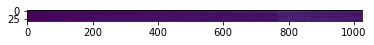

In [4]:
B=32

sample,p0 = pb.sample(B,op.L)
print(sample.shape)
ps = pb.logprobability(sample)

pvar,pmean = torch.var_mean(p0)

var,mean = torch.var_mean(abs(p0-ps))

print("Mean Difference:",mean.item(),"(Var[P])^0.5:",pvar.item()**0.5)

print("--------------------")



def get_indices(patch,L):
    sflip = torch.arange(L,device=device).to(torch.int64).reshape([1,L])
    sflip = patch(sflip).reshape(L)
    
    return sflip

probs = Sampler.off_diag_labels(pb,sample,nloops=op.NLOOPS)[:,get_indices(pb.patch,op.L)]
p2 = pb.off_diag_labels(sample,nloops=op.NLOOPS)

print("Mean Difference:",abs(probs-p2).mean().item(),"(Var[P])^0.5:",torch.var_mean(probs)[0].item()**0.5)
print(probs.mean(),p2.mean())
print(abs(probs-p2).max())
plt.imshow(abs(probs-p2).cpu())

In [3]:
pb.tokenize

Sequential(
  (0): Linear(in_features=16, out_features=128, bias=True)
  (1): Tanh()
)

In [4]:
pb = torch.jit.script(pb)


beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
pb.parameters(), 
lr=op.lr,
betas=(beta1,beta2)
)

mydir=setup_dir(op)
orig_stdout = sys.stdout
f = open(mydir+'\\output.txt', 'w')
sys.stdout = f
try:
    if not op.USEQUEUE:
        debug = reg_train(op,(pb,optimizer),printf=True,mydir=mydir)
except Exception as e:
    print(e)
sys.stdout = orig_stdout
f.close()

Output folder path established


In [2]:
op.steps=10

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
pb.parameters(), 
lr=op.lr,
betas=(beta1,beta2)
)

debug = reg_train(op,(pb,optimizer))
debug[-1,5]/op.L

Output folder path established
-0.3724 576
5,3.272|
48.44205188751221 10


0.26799843046400285

In [8]:
import os
os.system("python RNN_QSR.py hamiltonian=TFIM L=40 NLOOPS=10 h=-1 J=1 patch=1")

0

In [3]:
os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

0

In [4]:
import IPython
IPython.display.display(IPython.display.Javascript("IPython.notebook.save_notebook()"),include=['application/javascript'])

os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

0

In [2]:
from RNN_QSR import *

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)


In [9]:
import os
os.system("python RNN_QSR.py patch=2 --rnn _2D=False patch=2")



0

In [11]:
os.system("python PTF.py patch=2x2 --ptf _2D=True patch=2")

0

In [2]:
import os
os.system("python PTF.py L=576 NLOOPS=64 patch=3x3 --ptf _2D=True patch=3")

0

In [ ]:
os.system("python PTF.py L=576 NLOOPS=144 patch=2x2 --ptf _2D=True patch=2")

In [ ]:
import os
os.system("python LPTF.py L=256 NLOOPS=64 patch=2x2 --lptf _2D=True patch=2 --rnn L=4 _2D=False patch=2 Nh=128")

In [4]:
import os
os.system("python LPTF.py L=576 NLOOPS=64 patch=3x3B --lptf _2D=True patch=3 --rnn L=9 _2D=False patch=3 Nh=128")

0

In [ ]:
import os
os.system("python PTF.py L=64 NLOOPS=16 K=1024 patch=2x2 --ptf _2D=True patch=2")

In [12]:
import os
os.system("python ModelLoader.py PTF\\Rydberg\\64-B=1024-K=1024-P=2x2\\1 4096")

0

In [17]:
import os
os.system("python ModelBuilder.py L=16 NLOOPS=4 K=1024 patch=2x2 --ptf _2D=True patch=2")

0

In [10]:
import os
os.system("python LPTF.py L=576 NLOOPS=9 patch=8x8 --lptf _2D=True patch=8 --rnn L=64 _2D=True patch=2 Nh=128")


0

In [11]:
os.system("python LPTF.py L=576 NLOOPS=9 patch=8x8B --lptf _2D=True patch=8 --rnn L=64 _2D=False patch=8 Nh=128")

0

In [17]:
import os
os.system("python FineTune.py LPTF\\Rydberg\\576-B=256-K=256-P=8x8B\\0 L=2304 NLOOPS=36 K=64 Q=4 steps=4000 patch=8x8_LPTF")

KeyboardInterrupt: 

In [1]:
import os
os.system("python Transfer.py FINE-TUNE\\Rydberg\\2304-B=256-K=64-P=8x8_LPTF\\0 L=2304 K=64 Q=8 B=512 steps=4000 patch=2x2_PTF --ptf _2D=True patch=2")

1

In [2]:
import os
os.system("python Transfer.py FINE-TUNE\\Rydberg\\2304-B=256-K=64-P=8x8_LPTF\\0 L=2304 K=32 Q=2 B=64 steps=20 patch=2x2_PTF --ptf _2D=True patch=2")

0

In [7]:
import os
os.system("python ModelLoader.py TRANSFER\\Rydberg\\2304-B=512-K=64-P=2x2_PTF\\1 1024 32")

0

In [17]:
os.system("python FineTune.py TRANSFER\\Rydberg\\2304-B=512-K=64-P=2x2_PTF\\1 L=2304 NLOOPS=576 K=8 Q=8 lr=1e-4 B=64 steps=100 patch=2x2_PTF")

0

In [18]:
os.system("python ModelLoader.py FINE-TUNE\\Rydberg\\2304-B=64-K=8-P=2x2_PTF\\0 1024 32")

0

In [8]:
os.system("python ModelLoader.py FINE-TUNE\\Rydberg\\2304-B=256-K=64-P=8x8_LPTF\\0 1024 64")

0

In [24]:
os.system("python Transfer.py FINE-TUNE\\Rydberg\\2304-B=256-K=64-P=8x8_LPTF\\0 L=2304 K=512 Q=1 B=512 NLOOPS=144 steps=4000 patch=4x4_LPTF --lptf _2D=True patch=4 --rnn L=16 _2D=True patch=2 Nh=128")

0

In [28]:
os.system("python Transfer.py FINE-TUNE\\Rydberg\\2304-B=256-K=64-P=8x8_LPTF\\0 L=2304 K=512 Q=1 B=512 NLOOPS=64 steps=4000 patch=6x6_LPTF --lptf _2D=True patch=6 --rnn L=36 _2D=True patch=2 Nh=128")

0

In [25]:
os.system("python ModelLoader.py TRANSFER\\Rydberg\\2304-B=512-K=512-P=4x4_LPTF\\0 1024 32")

0

In [27]:
os.system("python FineTune.py TRANSFER\\Rydberg\\2304-B=512-K=512-P=4x4_LPTF\\0 L=2304 NLOOPS=144 K=64 Q=4 B=256 steps=2000 patch=4x4_LPTF")

0

In [29]:
os.system("python FineTune.py TRANSFER\\Rydberg\\2304-B=512-K=512-P=6x6_LPTF\\0 L=2304 NLOOPS=64 K=64 Q=4 B=256 steps=3000 patch=6x6_LPTF")

0

In [ ]:
os.system("python ModelBuilder.py L=144 NLOOPS=9 patch=2x2 --ptf _2D=True patch=2")